In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from os import listdir
sounds = os.listdir('/content/drive/MyDrive/Colab Notebooks/audio-cats-and-dogs/cats_dogs')
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/audio-cats-and-dogs"))

['cats_dogs']


In [3]:
import glob
import ntpath
Test_root = glob.glob('/content/drive/MyDrive/Colab Notebooks/audio-cats-and-dogs/cats_dogs/test')[0]
Train_root = glob.glob('/content/drive/MyDrive/Colab Notebooks/audio-cats-and-dogs/cats_dogs/train')[0]
X_path = glob.glob(Test_root + "/dogs/*")
X_path = X_path + glob.glob(Test_root + "/cats/*")
X_path = X_path + glob.glob(Train_root + "/dog/*")
X_path = X_path + glob.glob(Train_root + "/cat/*")

In [4]:
y = np.empty((0, 1, ))
for f in X_path:
    if 'cat' in ntpath.basename(f):
        resp = np.array([0])
        resp = resp.reshape(1, 1, )
        y = np.vstack((y, resp))
    elif 'dog' in ntpath.basename(f):
        resp = np.array([1])
        resp = resp.reshape(1, 1, )
        y = np.vstack((y, resp))
print (f)

/content/drive/MyDrive/Colab Notebooks/audio-cats-and-dogs/cats_dogs/train/cat/cat_50.wav


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_path, y, test_size=0.25)

In [6]:
def read_wav_files(wav_files):
    '''Returns a list of audio waves
    Params:
        wav_files: List of .wav paths
    
    Returns:
        List of audio signals
    '''
    if not isinstance(wav_files, list):
        wav_files = [wav_files]
    return [sci_wav.read(f)[1] for f in wav_files]

In [7]:
def librosa_read_wav_files(wav_files):
    if not isinstance(wav_files, list):
        wav_files = [wav_files]
    return [librosa.load(f)[0] for f in wav_files]

In [11]:
%%time
import librosa
wav_rate = librosa.load(X_train[0])[1]
X_train = librosa_read_wav_files(X_train)
X_test  = librosa_read_wav_files(X_test)

CPU times: user 43 s, sys: 7.16 s, total: 50.2 s
Wall time: 1min 17s


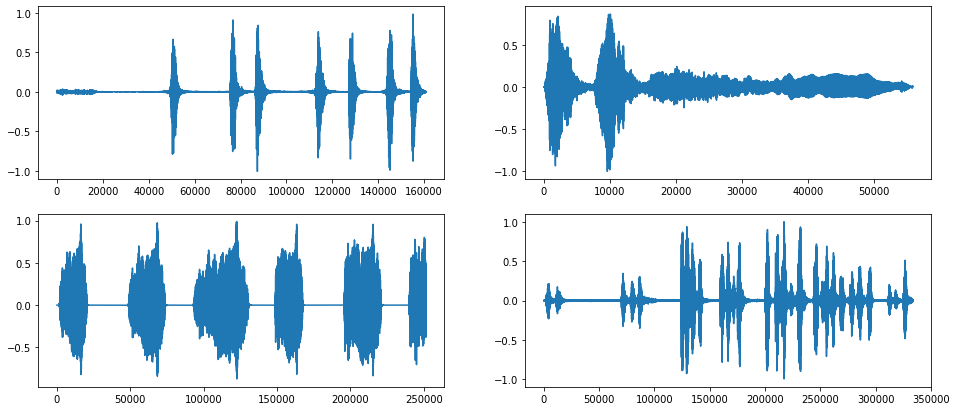

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(16,7))
axs[0][0].plot(X_train[0])
axs[0][1].plot(X_train[1])
axs[1][0].plot(X_train[2])
axs[1][1].plot(X_train[3])
plt.show()

In [14]:
def extract_features(audio_samples, sample_rate):
    extracted_features = np.empty((0, 41, ))
    if not isinstance(audio_samples, list):
        audio_samples = [audio_samples]
        
    for sample in audio_samples:
        zero_cross_feat = librosa.feature.zero_crossing_rate(sample).mean()
        mfccs = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        mfccsscaled = np.append(mfccsscaled, zero_cross_feat)
        mfccsscaled = mfccsscaled.reshape(1, 41, )
        extracted_features = np.vstack((extracted_features, mfccsscaled))
    return extracted_features

1
(1, 41)


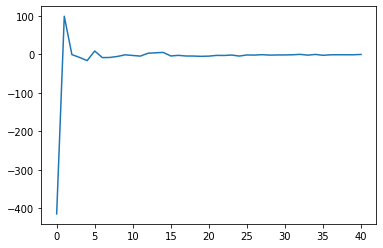

In [15]:
features = ((extract_features(X_train[0], wav_rate)))

print (len(features))
print (features.shape)
plt.plot(features[0])

In [16]:
X_train_features = extract_features(X_train, wav_rate)
X_test_features  = extract_features(X_test, wav_rate)
print("Image array shape: ", X_train_features.shape)
print("Image array shape: ", X_test_features.shape)
print("Label array shape: ", y_train.shape)
print("Label array shape: ", y_test.shape)

Image array shape:  (207, 41)
Image array shape:  (70, 41)
Label array shape:  (207, 1)
Label array shape:  (70, 1)


In [17]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [18]:
from keras.utils import to_categorical
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [19]:
model = models.Sequential()

model.add(layers.Dense(100, activation = 'relu', input_shape = (41, )))
model.add(layers.Dense(50, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4200      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 9,352
Trainable params: 9,352
Non-trainable params: 0
_________________________________________________________________


In [20]:
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)

callbacks = [checkpoint]

model.compile(optimizer='adam',
              loss=losses.categorical_crossentropy,
              metrics=['accuracy'])

In [21]:
history = model.fit(
    X_train_features,
    train_labels,
    validation_data=(X_test_features,test_labels),
    epochs = 200, 
    verbose = 1,
    callbacks=callbacks,
)

Epoch 1/200
7/7 [==============================] - 1s 67ms/step - loss: 4.6256 - accuracy: 0.5277 - val_loss: 2.6098 - val_accuracy: 0.6571
Epoch 2/200
7/7 [==============================] - 0s 9ms/step - loss: 1.7978 - accuracy: 0.7265 - val_loss: 2.2491 - val_accuracy: 0.7857
Epoch 3/200
7/7 [==============================] - 0s 9ms/step - loss: 0.7563 - accuracy: 0.8790 - val_loss: 1.7358 - val_accuracy: 0.7429
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.7375 - accuracy: 0.8283 - val_loss: 1.4880 - val_accuracy: 0.8857
Epoch 5/200
7/7 [==============================] - 0s 9ms/step - loss: 0.3912 - accuracy: 0.9126 - val_loss: 1.1528 - val_accuracy: 0.8286
Epoch 6/200
7/7 [==============================] - 0s 8ms/step - loss: 0.5372 - accuracy: 0.8908 - val_loss: 1.0328 - val_accuracy: 0.8857
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 0.2953 - accuracy: 0.9140 - val_loss: 0.9409 - val_accuracy: 0.8286
Epoch 8/200
7/7 [=========

In [22]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


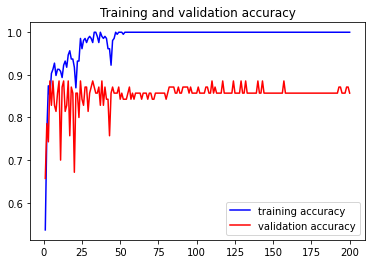

In [23]:
print(history.history.keys())

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label = "training accuracy")
plt.plot(epochs, val_acc, 'r', label = "validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

Cat: 0.4638488292694092 Dog: 0.5361511707305908
This is a cat meowing


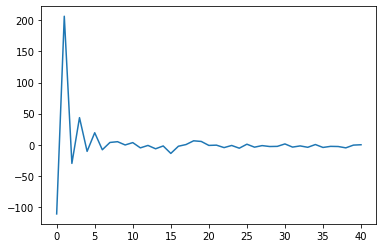

In [40]:
nr_to_predict = 69
pred = model.predict(X_test_features[nr_to_predict].reshape(1, 41,))

print("Cat: {} Dog: {}".format(pred[0][0], pred[0][1]))

if (y_test[nr_to_predict] == 0):
    print ("This is a cat meowing")
else:
    print ("This is a dog barking")
    
plt.plot(X_test_features[nr_to_predict])
ipd.Audio(X_test[nr_to_predict],  rate=wav_rate)

Cat: 7.849970131389161e-13 Dog: 1.0
This is a dog barking


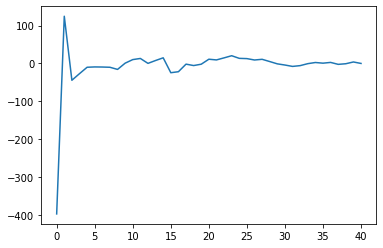

In [39]:
nr_to_predict = 5
pred = model.predict(X_test_features[nr_to_predict].reshape(1, 41,))

print("Cat: {} Dog: {}".format(pred[0][0], pred[0][1]))

if (y_test[nr_to_predict] == 0):
    print ("This is a cat meowing")
else:
    print ("This is a dog barking")
    
plt.plot(X_test_features[nr_to_predict])
ipd.Audio(X_test[nr_to_predict],  rate=wav_rate)